In [1]:
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import cv2
from scipy.linalg import cho_factor, cho_solve

In [2]:
# Max index = number of unknowns
def getVarIndex(x,y,width,height):
    return y+(x*width)

In [29]:
# Normal system
def setUpNormalSystem(width,height,constraints):

    # Constraints to array
    constraints_np = np.array(constraints)
    const_mat  = np.full((height, width),-1.,np.float)
    weight_mat = np.full((height, width),0.,np.float)
    
    const_mat[constraints_np[:, 0].astype(int), constraints_np[:, 1].astype(int)]  = constraints_np[:, 2]
    weight_mat[constraints_np[:, 0].astype(int), constraints_np[:, 1].astype(int)] = constraints_np[:, 3]
    
    # Triplet list -> (indx_constraint, unknown, val)
    A_triplet_list = []
    b_list = []
    row = 0
    
    # Set up constraints
    for x in range(0,width):
        for y in range(0,height):
            #print(x,y," --> ",getVarIndex(x,y,width,height))
            # Horizontal Smoothness
            if((x+1)!=width):
                A_triplet_list.append((row,getVarIndex(x,y,width,height),-1))
                A_triplet_list.append((row,getVarIndex(x+1,y,width,height),1))
                row = row + 1

            # Vertical Smoothness
            if((y+1)!=height):
                A_triplet_list.append((row,getVarIndex(x,y,width,height),-1))
                A_triplet_list.append((row,getVarIndex(x,y+1,width,height),1))
                row = row + 1

            # Constraints 
            if(const_mat[x,y]!=-1.):
                A_triplet_list.append((row,getVarIndex(x,y,width,height),weight_mat[x,y]))
                b_list.append((row,weight_mat[x,y]*const_mat[x,y]))              
                row = row + 1
                #print(row,weight_mat[x,y]*const_mat[x,y])

    # Convert triplets to matrix A
    a = np.array(A_triplet_list)
    ymax = int(a[:, 0].max())
    xmax = int(a[:, 1].max())
    A = np.zeros((ymax+1, xmax+1), np.float)
    A[a[:, 0].astype(int), a[:, 1].astype(int)] = a[:, 2]
    A = A.astype(float)

    # Convert triplets to vector b
    const = np.array(b_list)
    b = np.zeros((A.shape[0]), np.float)
    b[const[:, 0].astype(int)] = const[:, 1]

    return A, b

In [30]:
# Interpolation solver
def solveWithNormalEquation(width,height,constraints):
    # Set up linear system
    A, b = setUpNormalSystem(width,height,constraints)
    # Solve with Cholesky
    c, low = cho_factor(np.matmul(np.transpose(A),A))
    x = cho_solve((c, low), np.matmul(np.transpose(A),b))
    img = x.reshape((width, height))
    return img

In [55]:
# Set area size (number of cels = w*h)
width  = 60
height = 60

# Set list of constraints (format: [(x,y,value,weight),(x,y,value,weight),(x,y,value,weight),...])
# x and y must be in range (0 -> width-1, 0 -> height-1)
# value must be in range 0->255 (higher values can be used, but need to be properly scaled to RGB aftewards)
# We set constraints on each chanel (RGB) independently
# Weight is provided to be able to specify different impacts of each constraint over the final interpolation,
# it must be a positive float
constraints_r = [(15,30,255.,10.),(30,15,127.,10.),(45,30,255.,10.),(30,45,128.,10.)]
constraints_g = [(15,30,0.,10.)  ,(30,15,255.,10.),(45,30,128.,10.),(30,45,128.,10.)]
constraints_b = [(15,30,255.,10.),(30,15,0.,10.)  ,(45,30,0.,10.),(30,45,255.,10.)]

In [56]:
# Solve linear interpolation on each channel
interpolated_r = solveWithNormalEquation(width,height,constraints_r)
interpolated_g = solveWithNormalEquation(width,height,constraints_g)
interpolated_b = solveWithNormalEquation(width,height,constraints_b)

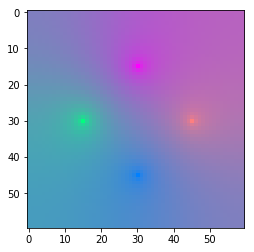

In [69]:
# Concat channels into rgb image
interpolated_img = np.zeros([width,height,3])
interpolated_img[:,:,0] = interpolated_b
interpolated_img[:,:,1] = interpolated_g
interpolated_img[:,:,2] = interpolated_r
interpolated_img = interpolated_img.astype(int)

# Show
plt.imshow(interpolated_img)